# GSE176078 Exploration

## Table of Contents
1. [Imports](#imports)
2. [Path for Assets](#path-for-assets)
3. [Data Loading](#data-loading)
4. [Data Preparation and Feature Selection](#data-preparation-and-feature-selection)
5. [Gene Lists and Filtering](#gene-lists-and-filtering)
6. [OBS File Generation](#OBS-File-Generation)

## Imports

In [1]:
# Necessary imports for the notebook. Please ensure these libraries are installed in your Python environment, if not then please install them using the requirements.txt file.
import os
from scipy.io import mmread
import pandas as pd
import scanpy as sc
import numpy as np
import urllib.request
from gtfparse import read_gtf
import infercnvpy as cnv
import matplotlib.pyplot as plt
import seaborn as sns

a:\Capstone Local-GIt\ghost-cell-busters\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


___

## Path for Assets

In [ ]:
# This is the relative path of the assets directory, if the assets are in another location please change the path accordingly.
assets = "../assets"

___

## Data Loading
The following set of code blocks contain the necessary data imports for the GSE176078 dataset. The data includes gene information, barcodes, and metadata.

In [ ]:
X = mmread(f"""{assets}/GSE176078/count_matrix_sparse.mtx""").tocsr().T
X

<Compressed Sparse Column sparse matrix of dtype 'int64'
	with 177994136 stored elements and shape (100064, 29733)>

In [4]:
# Create AnnData
adata = sc.AnnData(X)
adata

AnnData object with n_obs × n_vars = 100064 × 29733

In [ ]:
# Load genes
genes = pd.read_csv(f"""{assets}/GSE176078/count_matrix_genes.tsv""", sep="\t", header=None)
genes.columns = ["gene_id"]
genes.head()

,gene_id
0,RP11-34P13.7
1,FO538757.3
2,FO538757.2
3,AP006222.2
4,RP4-669L17.10


In [ ]:
# Load barcodes
barcodes = pd.read_csv(f"""{assets}/GSE176078/count_matrix_barcodes.tsv""", sep="\t", header=None)
barcodes.columns = ["cell_id"]
barcodes.head()

,cell_id
0,CID3586_AAGACCTCAGCATGAG
1,CID3586_AAGGTTCGTAGTACCT
2,CID3586_ACCAGTAGTTGTGGCC
3,CID3586_ACCCACTAGATGTCGG
4,CID3586_ACTGATGGTCAACTGT


In [ ]:
# Load metadata
metadata = pd.read_csv(f"""{assets}/GSE176078/metadata.csv""")
metadata.head()

,Unnamed: 0,orig.ident,nCount_RNA,nFeature_RNA,percent.mito,subtype,celltype_subset,celltype_minor,celltype_major
0,CID3586_AAGACCTCAGCATGAG,CID3586,4581,1689,1.506221,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial
1,CID3586_AAGGTTCGTAGTACCT,CID3586,1726,779,5.793743,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial
2,CID3586_ACCAGTAGTTGTGGCC,CID3586,1229,514,1.383238,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial
3,CID3586_ACCCACTAGATGTCGG,CID3586,1352,609,1.923077,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial
4,CID3586_ACTGATGGTCAACTGT,CID3586,1711,807,13.325541,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial


___

## Data Preparation and Feature Selection.

In [8]:
# Set .var_names using gene IDs
adata.var_names = genes["gene_id"].astype(str).values
adata.var_names_make_unique()
adata.var.head()

""
RP11-34P13.7
FO538757.3
FO538757.2
AP006222.2
RP4-669L17.10


In [9]:
# Set .obs using barcodes and align metadata
adata.obs_names = barcodes["cell_id"].astype(str).values
metadata.index = adata.obs_names
adata.obs = metadata
adata.obs.head()

,Unnamed: 0,orig.ident,nCount_RNA,nFeature_RNA,percent.mito,subtype,celltype_subset,celltype_minor,celltype_major
CID3586_AAGACCTCAGCATGAG,CID3586_AAGACCTCAGCATGAG,CID3586,4581,1689,1.506221,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial
CID3586_AAGGTTCGTAGTACCT,CID3586_AAGGTTCGTAGTACCT,CID3586,1726,779,5.793743,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial
CID3586_ACCAGTAGTTGTGGCC,CID3586_ACCAGTAGTTGTGGCC,CID3586,1229,514,1.383238,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial
CID3586_ACCCACTAGATGTCGG,CID3586_ACCCACTAGATGTCGG,CID3586,1352,609,1.923077,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial
CID3586_ACTGATGGTCAACTGT,CID3586_ACTGATGGTCAACTGT,CID3586,1711,807,13.325541,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial


In [10]:
adata.obs['celltype_major'].value_counts()

celltype_major
T-cells              35214
Cancer Epithelial    24489
Myeloid               9675
Endothelial           7605
CAFs                  6573
PVL                   5423
Normal Epithelial     4355
Plasmablasts          3524
B-cells               3206
Name: count, dtype: int64

In [11]:
adata.obs['celltype_minor'].value_counts()

celltype_minor
T cells CD4+                   19231
T cells CD8+                   11487
Cancer LumA SC                  7742
Macrophage                      5929
Cancer Cycling                  5359
Endothelial ACKR1               4611
Cancer Basal SC                 4312
Cancer Her2 SC                  3708
Plasmablasts                    3524
PVL Differentiated              3487
CAFs myCAF-like                 3420
Cancer LumB SC                  3368
CAFs MSC iCAF-like              3153
B cells Memory                  2581
Monocyte                        2328
Luminal Progenitors             1992
PVL Immature                    1886
NK cells                        1846
Endothelial CXCL12              1644
Cycling T-cells                 1528
Mature Luminal                  1265
Endothelial RGS5                1147
NKT cells                       1122
Myoepithelial                   1098
DCs                              955
B cells Naive                    625
Cycling_Myeloid        

In [12]:
adata.obs['subtype'].value_counts()

subtype
TNBC     42512
ER+      38241
HER2+    19311
Name: count, dtype: int64

## Gene Lists and Filtering

In [ ]:
# Genes for cell cycle phases
s_genes = [
    'MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG', 'GINS2',
    'MCM6', 'CDCA7', 'DTL', 'PRIM1', 'UHRF1', 'MCM10', 'HELLS', 'RFC2', 'RPA2',
    'NASP', 'RAD51AP1', 'GMNN', 'WDR76', 'SLBP', 'CCNE2', 'UBR7', 'POLD3',
    'MSH2', 'ATAD2', 'RAD51', 'RRM2', 'CDC45', 'CDC6', 'EXO1', 'TIPIN', 'DSCC1',
    'BLM', 'CASP8AP2', 'USP1', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8'
]

g2m_genes = [
    'HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80',
    'CKS2', 'NUF2', 'CKS1B', 'MKI67', 'TMPO', 'CENPF', 'TACC3', 'FAM64A',
    'SMC4', 'CCNB2', 'CKAP2L', 'CKAP2', 'AURKB', 'BUB1', 'KIF11', 'ANP32E',
    'TUBB4B', 'GTSE1', 'KIF20B', 'HJURP', 'CDC20', 'TTK', 'CDC25C', 'KIF2C',
    'RANGAP1', 'NCAPD2', 'DLGAP5', 'CDCA3', 'HN1', 'CDC45', 'CDCA8', 'ECT2',
    'KIF23', 'HMMR', 'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CENPE',
    'CTCF', 'NEK2', 'G2E3', 'GAS2L3', 'CBX5', 'CENPA'
]

apoptosis_genes = [
    'BAX', 'BAK1', 'CASP3', 'CASP8', 'BCL2L11', 'FAS', 'TP53', 'BBC3', 'CYCS'
]

oxphos_genes = [
    "ATP5F1A", "ATP5F1B", "ATP5MC1", "ATP5MC2", "ATP5ME", "ATP5MG",
    "COX4I1", "COX5A", "COX6A1", "COX6C", "NDUFA1", "NDUFA2", "NDUFA4",
    "NDUFAB1", "NDUFB2", "NDUFB3", "NDUFS1", "NDUFS2", "NDUFV1", "UQCRC1",
    "UQCRC2", "UQCRH", "SDHA", "SDHB", "SDHC", "SDHD", "CYCS"
]

proto_oncogenes = [
    'MYC', 'KRAS', 'EGFR', 'BRAF', 'AKT1', 'PIK3CA', 'CCND1', 'ERBB2', 'FGFR1', 'MDM2'
]

In [ ]:
# Filtering for genes present in the dataset
s_genes = [g for g in s_genes if g in adata.var_names]
g2m_genes = [g for g in g2m_genes if g in adata.var_names]

# Compute cell cycle scores
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
adata.obs.head()

,Unnamed: 0,orig.ident,nCount_RNA,nFeature_RNA,percent.mito,subtype,celltype_subset,celltype_minor,celltype_major,S_score,G2M_score,phase
CID3586_AAGACCTCAGCATGAG,CID3586_AAGACCTCAGCATGAG,CID3586,4581,1689,1.506221,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.038055,-0.312865,G1
CID3586_AAGGTTCGTAGTACCT,CID3586_AAGGTTCGTAGTACCT,CID3586,1726,779,5.793743,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.048626,-0.187135,G1
CID3586_ACCAGTAGTTGTGGCC,CID3586_ACCAGTAGTTGTGGCC,CID3586,1229,514,1.383238,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.016913,-0.127680,G1
CID3586_ACCCACTAGATGTCGG,CID3586_ACCCACTAGATGTCGG,CID3586,1352,609,1.923077,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.021142,-0.100390,G1
CID3586_ACTGATGGTCAACTGT,CID3586_ACTGATGGTCAACTGT,CID3586,1711,807,13.325541,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,0.012685,-0.171540,S


In [ ]:
# Filtering for apoptosis genes present in the dataset
apoptosis_genes = [gene for gene in apoptosis_genes if gene in adata.var_names]

# Compute score
sc.tl.score_genes(adata, gene_list=apoptosis_genes, score_name='apoptosis_score')
adata.obs.head()

,Unnamed: 0,orig.ident,nCount_RNA,nFeature_RNA,percent.mito,subtype,celltype_subset,celltype_minor,celltype_major,S_score,G2M_score,phase,apoptosis_score
CID3586_AAGACCTCAGCATGAG,CID3586_AAGACCTCAGCATGAG,CID3586,4581,1689,1.506221,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.038055,-0.312865,G1,-0.632049
CID3586_AAGGTTCGTAGTACCT,CID3586_AAGGTTCGTAGTACCT,CID3586,1726,779,5.793743,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.048626,-0.187135,G1,-0.286432
CID3586_ACCAGTAGTTGTGGCC,CID3586_ACCAGTAGTTGTGGCC,CID3586,1229,514,1.383238,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.016913,-0.127680,G1,-0.211055
CID3586_ACCCACTAGATGTCGG,CID3586_ACCCACTAGATGTCGG,CID3586,1352,609,1.923077,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.021142,-0.100390,G1,-0.216080
CID3586_ACTGATGGTCAACTGT,CID3586_ACTGATGGTCAACTGT,CID3586,1711,807,13.325541,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,0.012685,-0.171540,S,-0.306533


In [ ]:
# Identifing ribosomal genes
ribo_genes = [gene for gene in adata.var_names if gene.startswith('RPS') or gene.startswith('RPL')]

# Total counts per cell
total_counts = adata.X.sum(axis=1).A1 if isinstance(adata.X, np.matrix) or hasattr(adata.X, 'A1') else adata.X.sum(axis=1)

# Ribosomal counts per cell
ribo_counts = adata[:, ribo_genes].X.sum(axis=1).A1 if hasattr(adata[:, ribo_genes].X, 'A1') else adata[:, ribo_genes].X.sum(axis=1)

# Percent ribosomal
adata.obs['pct_counts_ribo'] = (ribo_counts / total_counts) * 100
adata.obs.head()

,Unnamed: 0,orig.ident,nCount_RNA,nFeature_RNA,percent.mito,subtype,celltype_subset,celltype_minor,celltype_major,S_score,G2M_score,phase,apoptosis_score,pct_counts_ribo
CID3586_AAGACCTCAGCATGAG,CID3586_AAGACCTCAGCATGAG,CID3586,4581,1689,1.506221,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.038055,-0.312865,G1,-0.632049,25.889544
CID3586_AAGGTTCGTAGTACCT,CID3586_AAGGTTCGTAGTACCT,CID3586,1726,779,5.793743,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.048626,-0.187135,G1,-0.286432,26.303592
CID3586_ACCAGTAGTTGTGGCC,CID3586_ACCAGTAGTTGTGGCC,CID3586,1229,514,1.383238,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.016913,-0.127680,G1,-0.211055,33.604557
CID3586_ACCCACTAGATGTCGG,CID3586_ACCCACTAGATGTCGG,CID3586,1352,609,1.923077,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.021142,-0.100390,G1,-0.216080,31.878698
CID3586_ACTGATGGTCAACTGT,CID3586_ACTGATGGTCAACTGT,CID3586,1711,807,13.325541,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,0.012685,-0.171540,S,-0.306533,19.929866


In [ ]:
# Filtering oxphos genes present in the dataset
oxphos_genes_present = [g for g in oxphos_genes if g in adata.var_names]
sc.tl.score_genes(adata, gene_list=oxphos_genes_present, score_name="oxphos_score")
adata.obs.head()

,Unnamed: 0,orig.ident,nCount_RNA,nFeature_RNA,percent.mito,subtype,celltype_subset,celltype_minor,celltype_major,S_score,G2M_score,phase,apoptosis_score,pct_counts_ribo,oxphos_score
CID3586_AAGACCTCAGCATGAG,CID3586_AAGACCTCAGCATGAG,CID3586,4581,1689,1.506221,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.038055,-0.312865,G1,-0.632049,25.889544,0.495952
CID3586_AAGGTTCGTAGTACCT,CID3586_AAGGTTCGTAGTACCT,CID3586,1726,779,5.793743,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.048626,-0.187135,G1,-0.286432,26.303592,0.075952
CID3586_ACCAGTAGTTGTGGCC,CID3586_ACCAGTAGTTGTGGCC,CID3586,1229,514,1.383238,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.016913,-0.127680,G1,-0.211055,33.604557,-0.024524
CID3586_ACCCACTAGATGTCGG,CID3586_ACCCACTAGATGTCGG,CID3586,1352,609,1.923077,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.021142,-0.100390,G1,-0.216080,31.878698,0.050714
CID3586_ACTGATGGTCAACTGT,CID3586_ACTGATGGTCAACTGT,CID3586,1711,807,13.325541,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,0.012685,-0.171540,S,-0.306533,19.929866,-0.081905


In [ ]:
# Protooncogene score
valid_protooncogenes = [g for g in proto_oncogenes if g in adata.var_names]
sc.tl.score_genes(adata, gene_list=oxphos_genes_present, score_name="proto_oncogenescore")
adata.obs.head()

,Unnamed: 0,orig.ident,nCount_RNA,nFeature_RNA,percent.mito,subtype,celltype_subset,celltype_minor,celltype_major,S_score,G2M_score,phase,apoptosis_score,pct_counts_ribo,oxphos_score,proto_oncogenescore
CID3586_AAGACCTCAGCATGAG,CID3586_AAGACCTCAGCATGAG,CID3586,4581,1689,1.506221,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.038055,-0.312865,G1,-0.632049,25.889544,0.495952,0.495952
CID3586_AAGGTTCGTAGTACCT,CID3586_AAGGTTCGTAGTACCT,CID3586,1726,779,5.793743,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.048626,-0.187135,G1,-0.286432,26.303592,0.075952,0.075952
CID3586_ACCAGTAGTTGTGGCC,CID3586_ACCAGTAGTTGTGGCC,CID3586,1229,514,1.383238,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.016913,-0.127680,G1,-0.211055,33.604557,-0.024524,-0.024524
CID3586_ACCCACTAGATGTCGG,CID3586_ACCCACTAGATGTCGG,CID3586,1352,609,1.923077,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.021142,-0.100390,G1,-0.216080,31.878698,0.050714,0.050714
CID3586_ACTGATGGTCAACTGT,CID3586_ACTGATGGTCAACTGT,CID3586,1711,807,13.325541,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,0.012685,-0.171540,S,-0.306533,19.929866,-0.081905,-0.081905


In [19]:
adata.obs.columns

Index(['Unnamed: 0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA',
       'percent.mito', 'subtype', 'celltype_subset', 'celltype_minor',
       'celltype_major', 'S_score', 'G2M_score', 'phase', 'apoptosis_score',
       'pct_counts_ribo', 'oxphos_score', 'proto_oncogenescore'],
      dtype='object')

In [20]:
gtf = read_gtf(f"""{assets}gencode.v44.annotation.gtf.gz""").to_pandas()
genes = gtf[gtf["feature"] == "gene"]
genes.head()

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'tag', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'hgnc_id', 'havana_gene', 'ont', 'protein_id', 'ccdsid', 'artif_dupl']


,seqname,source,feature,start,end,score,strand,frame,gene_id,gene_type,...,transcript_support_level,havana_transcript,exon_number,exon_id,hgnc_id,havana_gene,ont,protein_id,ccdsid,artif_dupl
0,chr1,HAVANA,gene,11869,14409,NaN,+,0,ENSG00000290825.1,lncRNA,...,,,,,,,,,,
5,chr1,HAVANA,gene,12010,13670,NaN,+,0,ENSG00000223972.6,transcribed_unprocessed_pseudogene,...,,,,,HGNC:37102,OTTHUMG00000000961.2,,,,
13,chr1,HAVANA,gene,14404,29570,NaN,-,0,ENSG00000227232.5,unprocessed_pseudogene,...,,,,,HGNC:38034,OTTHUMG00000000958.1,,,,
26,chr1,ENSEMBL,gene,17369,17436,NaN,-,0,ENSG00000278267.1,miRNA,...,,,,,HGNC:50039,,,,,
29,chr1,HAVANA,gene,29554,31109,NaN,+,0,ENSG00000243485.5,lncRNA,...,,,,,HGNC:52482,OTTHUMG00000000959.2,,,,


In [21]:
gene_pos = genes[["gene_name", "seqname", "start", "end"]].drop_duplicates()
gene_pos.columns = ["gene", "chromosome", "start", "end"]
gene_pos.head()

,gene,chromosome,start,end
0,DDX11L2,chr1,11869,14409
5,DDX11L1,chr1,12010,13670
13,WASH7P,chr1,14404,29570
26,MIR6859-1,chr1,17369,17436
29,MIR1302-2HG,chr1,29554,31109


In [22]:
# Merging gene location with adata.var
# Match gene names
adata.var["gene"] = adata.var_names
gene_pos_filtered = gene_pos[gene_pos["gene"].isin(adata.var["gene"])].drop_duplicates(subset="gene")
gene_pos_filtered = gene_pos_filtered.set_index("gene")

# Merge and reindex
merged_var = adata.var.join(gene_pos_filtered, on="gene")
merged_var = merged_var.reindex(adata.var_names)
adata.var = merged_var
adata.var.head()

,gene,chromosome,start,end
RP11-34P13.7,RP11-34P13.7,NaN,NaN,NaN
FO538757.3,FO538757.3,NaN,NaN,NaN
FO538757.2,FO538757.2,NaN,NaN,NaN
AP006222.2,AP006222.2,NaN,NaN,NaN
RP4-669L17.10,RP4-669L17.10,NaN,NaN,NaN


In [23]:
adata.var.dropna()

,gene,chromosome,start,end
LINC00115,LINC00115,chr1,824228.0,827539.0
FAM41C,FAM41C,chr1,868071.0,876903.0
SAMD11,SAMD11,chr1,923923.0,944575.0
NOC2L,NOC2L,chr1,944203.0,959309.0
KLHL17,KLHL17,chr1,960584.0,965719.0
...,...,...,...,...
GFRAL,GFRAL,chr6,55327469.0,55402493.0
GRXCR1,GRXCR1,chr4,42892713.0,43030658.0
LINC00919,LINC00919,chr16,52083064.0,52085109.0
KRTAP9-2,KRTAP9-2,chr17,41226648.0,41227652.0


In [ ]:
# Defining reference group using Normal Epithelial cells
# Create reference labels
adata.obs["cnv_reference"] = "tumor"
adata.obs.loc[adata.obs["celltype_major"] == "Normal Epithelial", "cnv_reference"] = "normal"


# inferCNV with infercnvpy
cnv.tl.infercnv(
    adata,
    reference_key="cnv_reference",
    reference_cat="normal",
    window_size=100,
    step=10,
    n_jobs=4
)

100%|██████████| 21/21 [02:13<00:00,  6.33s/it]


In [25]:
adata.obs

,Unnamed: 0,orig.ident,nCount_RNA,nFeature_RNA,percent.mito,subtype,celltype_subset,celltype_minor,celltype_major,S_score,G2M_score,phase,apoptosis_score,pct_counts_ribo,oxphos_score,proto_oncogenescore,cnv_reference
CID3586_AAGACCTCAGCATGAG,CID3586_AAGACCTCAGCATGAG,CID3586,4581,1689,1.506221,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.038055,-0.312865,G1,-0.632049,25.889544,0.495952,0.495952,tumor
CID3586_AAGGTTCGTAGTACCT,CID3586_AAGGTTCGTAGTACCT,CID3586,1726,779,5.793743,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.048626,-0.187135,G1,-0.286432,26.303592,0.075952,0.075952,tumor
CID3586_ACCAGTAGTTGTGGCC,CID3586_ACCAGTAGTTGTGGCC,CID3586,1229,514,1.383238,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.016913,-0.127680,G1,-0.211055,33.604557,-0.024524,-0.024524,tumor
CID3586_ACCCACTAGATGTCGG,CID3586_ACCCACTAGATGTCGG,CID3586,1352,609,1.923077,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.021142,-0.100390,G1,-0.216080,31.878698,0.050714,0.050714,tumor
CID3586_ACTGATGGTCAACTGT,CID3586_ACTGATGGTCAACTGT,CID3586,1711,807,13.325541,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,0.012685,-0.171540,S,-0.306533,19.929866,-0.081905,-0.081905,tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CID4398_TCAGGTAGTACTCAAC,CID4398_TCAGGTAGTACTCAAC,CID4398,6189,1251,2.698336,ER+,Myeloid_c0_DC_LAMP3,DCs,Myeloid,-0.084567,-0.435673,G1,-0.632607,16.400065,0.267619,0.267619,tumor
CID4398_TCTATTGTCGCCATAA,CID4398_TCTATTGTCGCCATAA,CID4398,4611,719,3.057905,ER+,Myeloid_c0_DC_LAMP3,DCs,Myeloid,-0.025370,-0.213450,G1,-0.381910,16.699198,0.048571,0.048571,tumor
CID4398_TCTTTCCCAGTAAGCG,CID4398_TCTTTCCCAGTAAGCG,CID4398,2987,887,3.682625,ER+,Myeloid_c0_DC_LAMP3,DCs,Myeloid,-0.029598,-0.207602,G1,-0.255723,17.140944,-0.014048,-0.014048,tumor
CID4398_TGCCCATGTTACGGAG,CID4398_TGCCCATGTTACGGAG,CID4398,5117,870,2.208325,ER+,Myeloid_c0_DC_LAMP3,DCs,Myeloid,-0.038055,-0.238791,G1,-0.123953,14.774282,0.201667,0.201667,tumor


In [26]:
# Cleaning and filtering chromosome annotations
adata.var["chromosome"] = adata.var["chromosome"].astype(str).str.replace("chr", "").str.upper()
valid_chroms = [str(i) for i in range(1, 23)] + ["X", "Y"]
filtered_var = adata.var[adata.var["chromosome"].isin(valid_chroms)]

# Taking a subset of the AnnData object using these genes
adata_chr = adata[:, filtered_var.index].copy()

sc.pp.scale(adata_chr, zero_center=False, max_value=10)

# Calculating per-chromosome CNV signal
chrom_scores = {}
for chrom in sorted(adata_chr.var["chromosome"].unique(), key=lambda x: (x not in "XY", x)):
    chrom_genes = adata_chr.var[adata_chr.var["chromosome"] == chrom].index
    if len(chrom_genes) < 10:
        continue
    expr = adata_chr[:, chrom_genes].X
    chrom_score = np.abs(expr).mean(axis=1)
    chrom_scores[chrom] = chrom_score

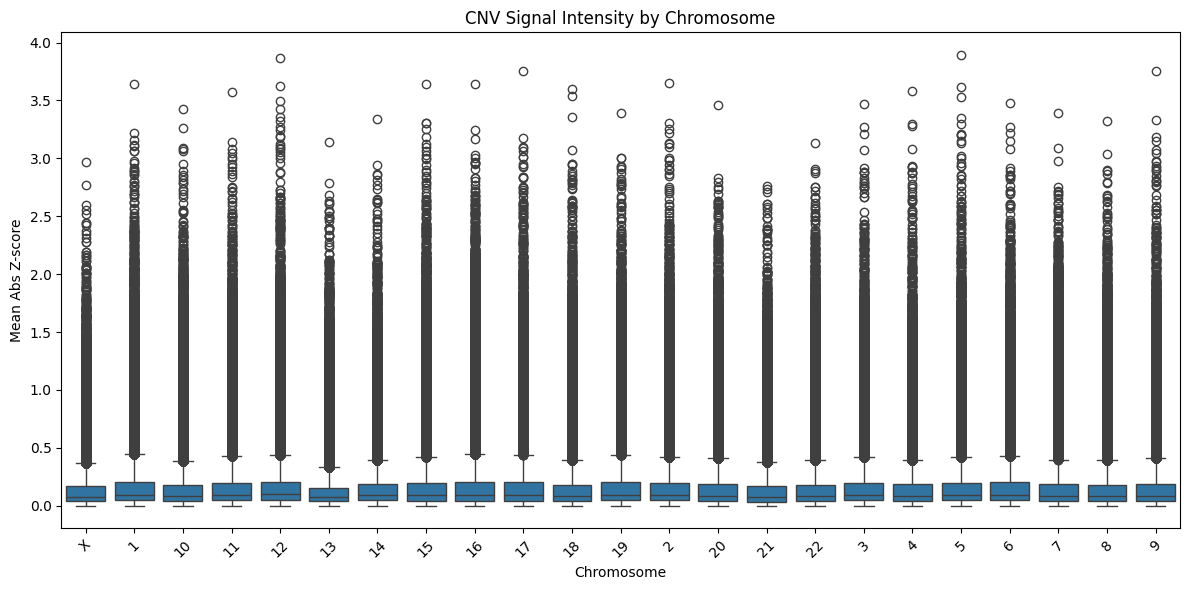

In [27]:
cnv_df = pd.DataFrame({chrom: chrom_scores[chrom].A1 if hasattr(chrom_scores[chrom], 'A1') else chrom_scores[chrom] for chrom in chrom_scores})
cnv_df = cnv_df.melt(var_name="Chromosome", value_name="Mean Abs Z-score")

plt.figure(figsize=(12, 6))
sns.boxplot(data=cnv_df, x="Chromosome", y="Mean Abs Z-score", order=sorted(cnv_df["Chromosome"].unique(), key=lambda x: (x not in "XY", x)))
plt.xticks(rotation=45)
plt.title("CNV Signal Intensity by Chromosome")
plt.tight_layout()
plt.show()

In [28]:
# Calculate the mean (or median, which is more robust to outliers) of Mean Abs Z-score for each chromosome
chromosome_cnv_summary = cnv_df.groupby("Chromosome")["Mean Abs Z-score"].mean().sort_values(ascending=False)

chromosome_cnv_summary

Chromosome
12    0.183753
16    0.182901
1     0.181897
19    0.180139
6     0.177581
17    0.176925
11    0.176908
2     0.176887
5     0.173779
15    0.173269
7     0.169667
3     0.169286
20    0.167187
9     0.166362
8     0.163770
22    0.161271
14    0.161179
4     0.159861
18    0.159651
10    0.157984
21    0.145990
X     0.144107
13    0.139477
Name: Mean Abs Z-score, dtype: float64

In [ ]:
adata.var["chromosome"] = adata.var["chromosome"].astype(str).str.replace("chr", "").str.upper()

# Define high-CNV burden chromosomes based on literature
selected_chroms = list(chromosome_cnv_summary.index)[:10]

# Taking a subset of genes from these chromosomes
cnv_genes = adata.var[adata.var["chromosome"].isin(selected_chroms)]

# Taking a subset of the AnnData object using these CNV-related genes
adata_cnv = adata[:, cnv_genes.index].copy()

# Normalize expression per gene (Z-score across all cells)
sc.pp.scale(adata_cnv, zero_center=False, max_value=10)

# Calculating CNV score as mean absolute Z-score per cell
adata.obs['cnv_score'] = np.abs(adata_cnv.X).mean(axis=1)

In [51]:
adata.obs.head()

,Unnamed: 0,orig.ident,nCount_RNA,nFeature_RNA,percent.mito,subtype,celltype_subset,celltype_minor,celltype_major,S_score,G2M_score,phase,apoptosis_score,pct_counts_ribo,oxphos_score,proto_oncogenescore,cnv_reference,cnv_score
CID3586_AAGACCTCAGCATGAG,CID3586_AAGACCTCAGCATGAG,CID3586,4581,1689,1.506221,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.038055,-0.312865,G1,-0.632049,25.889544,0.495952,0.495952,tumor,0.128104
CID3586_AAGGTTCGTAGTACCT,CID3586_AAGGTTCGTAGTACCT,CID3586,1726,779,5.793743,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.048626,-0.187135,G1,-0.286432,26.303592,0.075952,0.075952,tumor,0.043722
CID3586_ACCAGTAGTTGTGGCC,CID3586_ACCAGTAGTTGTGGCC,CID3586,1229,514,1.383238,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.016913,-0.127680,G1,-0.211055,33.604557,-0.024524,-0.024524,tumor,0.024811
CID3586_ACCCACTAGATGTCGG,CID3586_ACCCACTAGATGTCGG,CID3586,1352,609,1.923077,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,-0.021142,-0.100390,G1,-0.216080,31.878698,0.050714,0.050714,tumor,0.031385
CID3586_ACTGATGGTCAACTGT,CID3586_ACTGATGGTCAACTGT,CID3586,1711,807,13.325541,HER2+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,0.012685,-0.171540,S,-0.306533,19.929866,-0.081905,-0.081905,tumor,0.052013


___

## OBS File Generation.

In [59]:
adata.obs.columns

Index(['Unnamed: 0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA',
       'percent.mito', 'subtype', 'celltype_subset', 'celltype_minor',
       'celltype_major', 'S_score', 'G2M_score', 'phase', 'apoptosis_score',
       'pct_counts_ribo', 'oxphos_score', 'proto_oncogenescore',
       'cnv_reference', 'cnv_score'],
      dtype='object')

In [58]:
adata.var.columns

Index(['gene', 'chromosome', 'start', 'end'], dtype='object')

In [57]:
obs_file = adata.obs.copy()
obs_file.columns = ['cell_id', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'subtype', 'celltype_subset', 'celltype_minor', 'celltype_major', 'S_score', 'G2M_score', 'phase', 'apoptosis_score', 'pct_counts_ribo', 'oxphos_score', 'proto_oncogenescore', 'cnv_reference', 'cnv_score']
obs_file.to_csv(f"""{assets}GSE176078/GSE176078_obs.csv""", index=False)

In [60]:
var_file = adata.var.copy()
var_file.columns = ['gene', 'chromosome', 'start', 'end']
var_file.to_csv(f"""{assets}/GSE176078/GSE176078_var.csv""", index=False)

___

End of file: GSE176078_model.ipynb

Next section is in the GSE176078_model.ipynb file.